In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Concatenate, GaussianNoise, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd



import os
import glob

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import numpy as np
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [4]:
# network parameters
width = 64
height = 64
latent_dim = 100
inner_latent = 256
n_conds = 40


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(width,height,3), name='encoder_input')
condition = Input(shape=(n_conds,), name='encoder_condition')

x = GaussianNoise(1)(inputs) #Noise layer for denoising VAE
x = Conv2D(16, 3, strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(32, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(128, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)

(_,h,w,c) = x.shape

x = Flatten()(x)

x = Concatenate()([x,condition])

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model([inputs,condition], [z_mean, z_log_var, z, condition], name='encoder')
encoder.summary()



# # build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
decoder_condition = Input(shape=(n_conds,), name='decoder_condition')



x = Concatenate()([latent_inputs,decoder_condition])
x = Dense(h*w*c, activation='relu')(x)
x = Reshape((h,w,c))(x)
x = Conv2D(128,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(64,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(32,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(16,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)

outputs = Conv2D(3,3, strides=1, activation='tanh', padding='same')(x)


# # instantiate decoder model
decoder = Model([latent_inputs,decoder_condition], outputs, name='decoder')
decoder.summary()

# # instantiate VAE model




outputs = decoder([encoder([inputs, condition])[2], encoder([inputs, condition])[3]])
vae = Model([inputs, condition], outputs, name='cnn_vae')
vae.summary()
history = []

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 16)   448         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 32, 32, 16)   64          conv2d_4[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 32, 32, 16)   0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_condition_1:0
Model: "cnn_vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder_condition (InputLayer)  [(None, 40)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 100), (None, 516200      encoder_input[0][0]              
                                                                 encoder_condition[0][0]          
                                                    

In [5]:
decoder.load_weights('./checkpoints/epoch-1000-50kimgs-cond-decoder-weights.h5')
encoder.load_weights('./checkpoints/epoch-1000-50kimgs-cond-encoder-weights.h5')

In [449]:
decoder_big = load_model('./checkpoints/epoch-500-200kimgs-cond-decoder.h5')

In [368]:
inner_beta = K.variable(0.0)
def inner_vae_loss(y_true, y_pred):
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= 100 # common practice to scale with w*h
    kl_loss = 1 + u_log_var - K.square(u_mean) - K.exp(u_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5 * inner_beta
    return K.mean(reconstruction_loss + kl_loss)

optimizer = Adam(0.0008)
inner_vae.compile(optimizer=optimizer, loss=inner_vae_loss, experimental_run_tf_function=False)
loss_curve = []

In [7]:
encoder.load_weights('./checkpoints/epoch-100-200kimgs-cond-encoder-weights.h5')
decoder.load_weights('./checkpoints/epoch-0-200kimgs-cond-decoder-weights.h5')

In [16]:
#Beta VAE warmup
from tensorflow.keras.callbacks import Callback
class Warmup(Callback):
    def __init__(self, beta, warmup_epoch):
        self.warmup_epoch = warmup_epoch
        self.beta = beta

    def on_epoch_end(self, epoch, logs={}):
        value = (epoch/self.warmup_epoch) * (epoch <= self.warmup_epoch) + 1.0 * (epoch > self.warmup_epoch)
        K.set_value(self.beta, value)
        print(f' epoch {epoch}, beta = {K.get_value(self.beta)}')

def vae_loss(y_true, y_pred):
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= width*height # common practice to scale with w*h
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)
 

    
beta = K.variable(0.0)
def beta_vae_loss(y_true, y_pred):
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= width*height # common practice to scale with w*h
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    kl_loss * beta
    return K.mean(reconstruction_loss + kl_loss)




In [9]:
def normalize_for_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

In [628]:
import cv2
import numpy as np
import glob 
import pandas as pd

def data_loader(file_path):
    img_paths = glob.glob(file_path + '/0*[0-9][0-9][0-9].jpg')
    data = []
    for img_path in img_paths:
        data.append(normalize_for_tanh(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)))
    return np.array(data)



X = data_loader('../celeba-clean-64/')
df = pd.read_csv('./celeba-attribs.csv')
c = df[list(df.columns[1:])].to_numpy()


In [629]:
X_c = X, c[:X.shape[0],:]

In [17]:
def encode_to_attribs(encoded):
    for present, attrib in zip(encoded, list(df.columns[1:])):
        if present == 1:
            print(attrib)

In [19]:
optimizer = Adam(0.0008)
vae.compile(optimizer=optimizer, loss=vae_loss, experimental_run_tf_function=False)
loss_curve = []

In [20]:
df = pd.read_csv('./celeba-attribs.csv')

In [21]:
training_data_generator = ImageDataGenerator(
    validation_split=0.0,
    horizontal_flip=False,
    preprocessing_function=normalize_for_tanh)


training_generator = training_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='../celeba-clean-64/',
    x_col="img",
    y_col=list(df.columns[1:]),
    target_size=(64, 64),
    subset='training',
    shuffle=True,
    batch_size=202599,
    class_mode='raw')


Found 202599 validated image filenames.


In [22]:
training_data = training_generator.next()

In [22]:
len(training_imgs) // batch_size

3165

In [61]:
import time
epochs = 1001
batch_size = 32

model_type = '200kimgs-cond'

training_imgs = training_data[0]
training_cond = training_data[1]
num_batches = len(training_imgs) // batch_size

for epoch in range(501,epochs):
    start = time.time()
    print(f'Epoch [{epoch}/{epochs-1}]...'.ljust(20), end = '')

    np.random.seed(epoch)
    np.random.shuffle(training_imgs)
    np.random.seed(epoch)
    np.random.shuffle(training_cond)
    
    loss = 0
    for index in range(num_batches):
        img_input = training_imgs[index*batch_size: batch_size*(index+1)]
        condition_input = training_cond[index*batch_size: batch_size*(index+1)]
        loss += vae.train_on_batch([img_input, condition_input], img_input)
    
    loss /= num_batches
    

    
    print(f'...{time.time()-start:.3f}(s) loss: {loss:.3f}')
    loss_curve.append(loss)
    if epoch % 100 == 0:
        print(f'checkpointing at epoch: {epoch}')
        decoder.save_weights(f'./checkpoints/epoch-{epoch}-{model_type}-decoder-weights.h5')
        decoder.save(f'./checkpoints/epoch-{epoch}-{model_type}-decoder.h5')
        encoder.save_weights(f'./checkpoints/epoch-{epoch}-{model_type}-encoder-weights.h5')
        encoder.save(f'./checkpoints/epoch-{epoch}-{model_type}-encoder.h5')


Epoch [501/1000]... ...130.925(s) loss: 243.051
Epoch [502/1000]... ...130.896(s) loss: 243.022
Epoch [503/1000]... ...130.920(s) loss: 243.026
Epoch [504/1000]... ...130.794(s) loss: 243.042
Epoch [505/1000]... ...130.863(s) loss: 242.973
Epoch [506/1000]... ...130.863(s) loss: 243.019
Epoch [507/1000]... ...130.817(s) loss: 242.999
Epoch [508/1000]... ...130.631(s) loss: 243.048
Epoch [509/1000]... ...130.657(s) loss: 243.028
Epoch [510/1000]... ...130.714(s) loss: 243.045
Epoch [511/1000]... ...130.792(s) loss: 242.968
Epoch [512/1000]... ...130.713(s) loss: 242.990
Epoch [513/1000]... ...130.656(s) loss: 242.956
Epoch [514/1000]... ...130.656(s) loss: 242.977
Epoch [515/1000]... ...130.665(s) loss: 242.961
Epoch [516/1000]... ...126.934(s) loss: 242.974
Epoch [517/1000]... ...126.814(s) loss: 242.971
Epoch [518/1000]... ...127.050(s) loss: 242.979
Epoch [519/1000]... ...130.636(s) loss: 243.007
Epoch [520/1000]... ...130.435(s) loss: 242.952
Epoch [521/1000]... ...130.612(s) loss: 

KeyboardInterrupt: 

In [369]:
import time
start_epoch = 0
epochs = 201
warmup_epoch = 75
batch_size = 64

model_type = '200kimgs-cond-inner-vae'

training_imgs = training_data[0]
training_cond = training_data[1]
num_batches = len(training_imgs) // batch_size

for epoch in range(start_epoch,epochs):
    start = time.time()
    print(f'Epoch [{epoch}/{epochs-1}]...'.ljust(20), end = '')

    np.random.seed(epoch)
    np.random.shuffle(training_imgs)
    np.random.seed(epoch)
    np.random.shuffle(training_cond)
    
    loss = 0
    for index in range(num_batches):
        img_input = training_imgs[index*batch_size: batch_size*(index+1)]
        condition_input = training_cond[index*batch_size: batch_size*(index+1)]
        z_input = encoder.predict([img_input, condition_input])[2]
        loss += inner_vae.train_on_batch(z_input, z_input)
    
    
    
    
    loss /= num_batches
    print(f'...{time.time()-start:.3f}(s) loss: {loss:.3f}')
    
    # beta warmup
    value = (epoch/warmup_epoch) * (epoch <= warmup_epoch) + 1.0 * (epoch > warmup_epoch)
    K.set_value(inner_beta, value)
    print(f' epoch {epoch}, beta = {K.get_value(inner_beta)}')
    
    
    loss_curve.append(loss)
    if epoch % 100 == 0:
        print(f'checkpointing at epoch: {epoch}')
        decoder.save_weights(f'./checkpoints/epoch-{epoch}-{model_type}-decoder-weights.h5')
        decoder.save(f'./checkpoints/epoch-{epoch}-{model_type}-decoder.h5')
        encoder.save_weights(f'./checkpoints/epoch-{epoch}-{model_type}-encoder-weights.h5')
        encoder.save(f'./checkpoints/epoch-{epoch}-{model_type}-encoder.h5')


Epoch [0/200]...    ...129.188(s) loss: 64.591
 epoch 0, beta = 0.0
checkpointing at epoch: 0
Epoch [1/200]...    ...127.882(s) loss: 40.910
 epoch 1, beta = 0.013333333656191826
Epoch [2/200]...    ...127.819(s) loss: 40.244
 epoch 2, beta = 0.02666666731238365
Epoch [3/200]...    ...127.028(s) loss: 40.986
 epoch 3, beta = 0.03999999910593033
Epoch [4/200]...    ...127.328(s) loss: 42.132
 epoch 4, beta = 0.0533333346247673
Epoch [5/200]...    ...126.995(s) loss: 43.623
 epoch 5, beta = 0.06666667014360428
Epoch [6/200]...    ...126.871(s) loss: 45.060
 epoch 6, beta = 0.07999999821186066
Epoch [7/200]...    ...125.397(s) loss: 46.454
 epoch 7, beta = 0.09333333373069763
Epoch [8/200]...    ...125.170(s) loss: 47.718
 epoch 8, beta = 0.1066666692495346
Epoch [9/200]...    ...124.939(s) loss: 48.952
 epoch 9, beta = 0.11999999731779099
Epoch [10/200]...   ...125.261(s) loss: 50.150
 epoch 10, beta = 0.13333334028720856
Epoch [11/200]...   ...125.157(s) loss: 51.284
 epoch 11, beta = 0

Epoch [102/200]...  ...127.548(s) loss: 88.973
 epoch 102, beta = 1.0
Epoch [103/200]...  ...125.420(s) loss: 88.954
 epoch 103, beta = 1.0
Epoch [104/200]...  ...127.123(s) loss: 88.961
 epoch 104, beta = 1.0
Epoch [105/200]...  ...127.379(s) loss: 88.969
 epoch 105, beta = 1.0
Epoch [106/200]...  ...127.408(s) loss: 88.948
 epoch 106, beta = 1.0
Epoch [107/200]...  ...127.727(s) loss: 88.920
 epoch 107, beta = 1.0
Epoch [108/200]...  ...128.137(s) loss: 88.935
 epoch 108, beta = 1.0
Epoch [109/200]...  ...128.353(s) loss: 88.963
 epoch 109, beta = 1.0
Epoch [110/200]...  ...127.575(s) loss: 88.915
 epoch 110, beta = 1.0
Epoch [111/200]...  ...128.022(s) loss: 88.965
 epoch 111, beta = 1.0
Epoch [112/200]...  ...128.069(s) loss: 88.944
 epoch 112, beta = 1.0
Epoch [113/200]...  ...127.167(s) loss: 88.915
 epoch 113, beta = 1.0
Epoch [114/200]...  ...127.874(s) loss: 88.936
 epoch 114, beta = 1.0
Epoch [115/200]...  ...128.051(s) loss: 88.917
 epoch 115, beta = 1.0
Epoch [116/200]...  

In [522]:
inner_decoder.save_weights(f'./checkpoints/epoch-100-inner-decoder-weights.h5')
inner_decoder.save(f'./checkpoints/epoch-100-inner-decoder.h5')
inner_encoder.save_weights(f'./checkpoints/epoch-100-inner-encoder-weights.h5')
inner_encoder.save(f'./checkpoints/epoch-100-inner-encoder.h5')

In [79]:
z_input.shape

(32, 100)

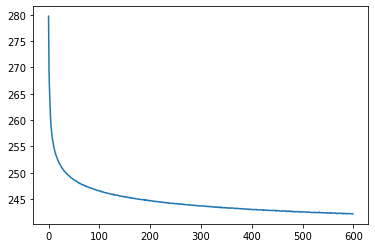

In [62]:
plt.plot(loss_curve)

In [635]:
val_imgs = X_c[0][15000:15010]
val_conds = X_c[1][15000:15010]

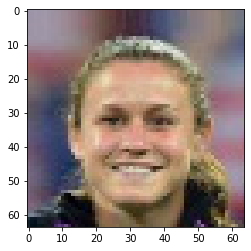

Bags_Under_Eyes
Brown_Hair
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Oval_Face
Smiling
Straight_Hair
Young
None


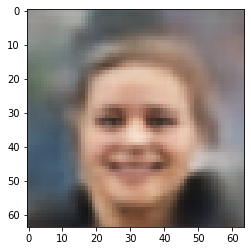

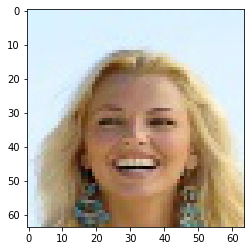

Arched_Eyebrows
Attractive
Big_Lips
Big_Nose
Blond_Hair
High_Cheekbones
Mouth_Slightly_Open
Narrow_Eyes
No_Beard
Smiling
Wavy_Hair
Wearing_Earrings
Wearing_Lipstick
Young
None


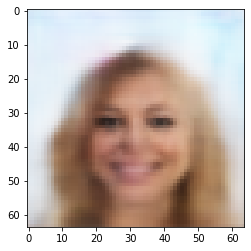

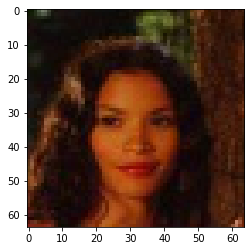

Attractive
Heavy_Makeup
No_Beard
Wavy_Hair
Wearing_Lipstick
Young
None


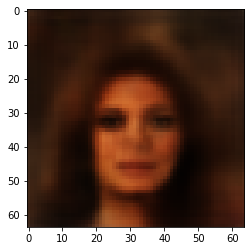

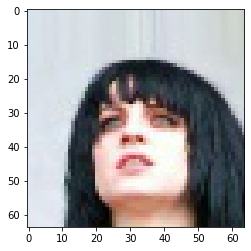

Bangs
Black_Hair
Heavy_Makeup
No_Beard
Pale_Skin
Straight_Hair
Young
None


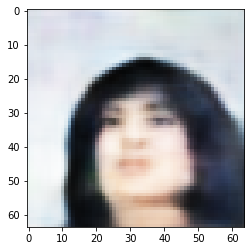

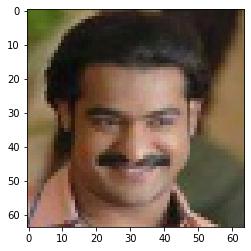

Black_Hair
Bushy_Eyebrows
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Oval_Face
Smiling
Young
None


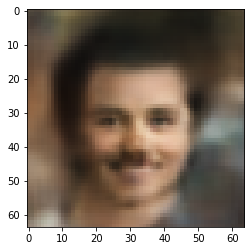

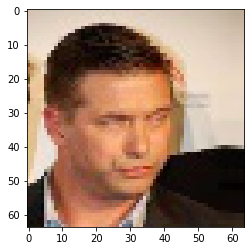

Black_Hair
Male
No_Beard
Oval_Face
Straight_Hair
Young
None


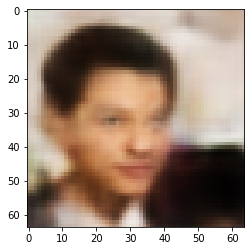

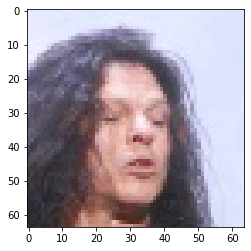

Blurry
Male
Narrow_Eyes
No_Beard
None


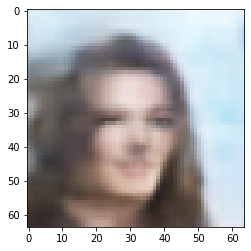

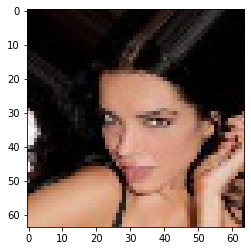

Attractive
Black_Hair
Heavy_Makeup
No_Beard
Pointy_Nose
Wearing_Lipstick
Young
None


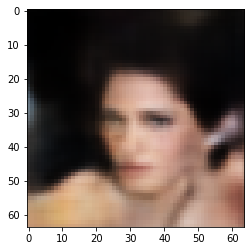

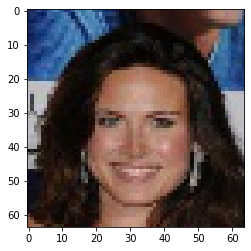

Arched_Eyebrows
Attractive
Big_Lips
Heavy_Makeup
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Oval_Face
Pointy_Nose
Rosy_Cheeks
Smiling
Wavy_Hair
Wearing_Earrings
Wearing_Lipstick
Young
None


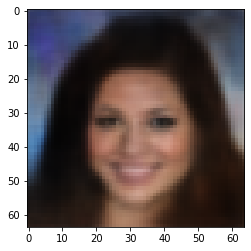

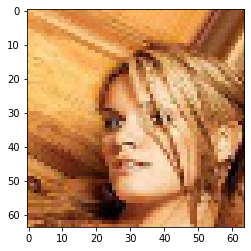

Attractive
Bangs
Blond_Hair
Mouth_Slightly_Open
No_Beard
Pointy_Nose
Wearing_Lipstick
Young
None


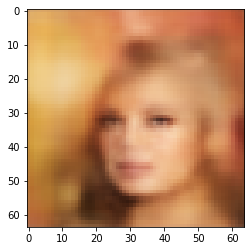

In [662]:
for image, cond in zip(val_imgs, val_conds):
    plt.imshow(unnormalize_tanh(image))
    plt.show()
    print(encode_to_attribs(cond))
    plt.imshow(unnormalize_tanh(vae.predict([np.array([image]),np.array([cond])])[0]))
    
    
    plt.show()

In [576]:
mu, sigma = 0, 1 #mean and standard deviation
s = np.random.normal(mu, sigma, latent_dim)
plt.imshow(decoder.predict([np.array([s]),np.array([conditions])])[0])
plt.show()

(40,)

In [93]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HBox, Label

In [412]:
attribs = '''5oClockShadow=1, Arched_Eyebrows=1, Attractive=1, Bags_Under_Eyes=1, Bald=1, Bangs=1, Big_Lips=1, Big_Nose=1, Black_Hair=1, Blond_Hair=1, Blurry=1, Brown_Hair=1, Bushy_Eyebrows=1, Chubby=1, Double_Chin=1, Eyeglasses=1, Goatee=1, Gray_Hair=1, Heavy_Makeup=1, High_Cheekbones=1, Male=1, Mouth_Slightly_Open=1, Mustache=1, Narrow_Eyes=1, No_Beard=1, Oval_Face=1, Pale_Skin=1, Pointy_Nose=1, Receding_Hairline=1, Rosy_Cheeks=1, Sideburns=1, Smiling=1, Straight_Hair=1, Wavy_Hair=1, Wearing_Earrings=1, Wearing_Hat=1, Wearing_Lipstick=1, Wearing_Necklace=1, Wearing_Necktie=1, Young'''
attribs = attribs.split('=1,')
attribs = [attrib.strip() for attrib in attribs]
print(f"=1, ".join(attribs))

5oClockShadow=1, Arched_Eyebrows=1, Attractive=1, Bags_Under_Eyes=1, Bald=1, Bangs=1, Big_Lips=1, Big_Nose=1, Black_Hair=1, Blond_Hair=1, Blurry=1, Brown_Hair=1, Bushy_Eyebrows=1, Chubby=1, Double_Chin=1, Eyeglasses=1, Goatee=1, Gray_Hair=1, Heavy_Makeup=1, High_Cheekbones=1, Male=1, Mouth_Slightly_Open=1, Mustache=1, Narrow_Eyes=1, No_Beard=1, Oval_Face=1, Pale_Skin=1, Pointy_Nose=1, Receding_Hairline=1, Rosy_Cheeks=1, Sideburns=1, Smiling=1, Straight_Hair=1, Wavy_Hair=1, Wearing_Earrings=1, Wearing_Hat=1, Wearing_Lipstick=1, Wearing_Necklace=1, Wearing_Necktie=1, Young


In [413]:
attrib_dict = {attrib:i for i,attrib in enumerate(attribs)}

In [115]:
sliders = []
labels = []
for attrib in attribs:
    slider = widgets.FloatSlider(
        min=-3,
        max=3,
        step=0.5,
        value=-1
    )
    labels.append(Label(attrib))
    sliders.append(slider)
for label, slider in zip(labels,sliders):
    display(label)
    display(slider)

Label(value='5_o_Clock_Shadow')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Arched_Eyebrows')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Attractive')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Bags_Under_Eyes')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Bald')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Bangs')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Big_Lips')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Big_Nose')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Black_Hair')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Blond_Hair')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Blurry')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Brown_Hair')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Bushy_Eyebrows')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Chubby')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Double_Chin')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Eyeglasses')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Goatee')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Gray_Hair')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Heavy_Makeup')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' High_Cheekbones')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Male')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Mouth_Slightly_Open')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Mustache')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Narrow_Eyes')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' No_Beard')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Oval_Face')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Pale_Skin')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Pointy_Nose')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Receding_Hairline')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Rosy_Cheeks')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Sideburns')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Smiling')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Straight_Hair')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Wavy_Hair')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Wearing_Earrings')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Wearing_Hat')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Wearing_Lipstick')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Wearing_Necklace')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Wearing_Necktie')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

Label(value=' Young')

FloatSlider(value=-1.0, max=3.0, min=-3.0, step=0.5)

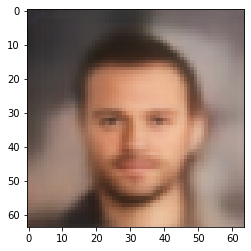

In [497]:
conditions = np.array([slider.value for slider in sliders])
mu, sigma = 0, 1 #mean and standard deviation
#s = np.random.normal(mu, sigma,latent_dim)
gen_img = unnormalize_tanh( decoder_big.predict([np.array([s]),np.array([conditions])])[0])
plt.imshow(gen_img)
plt.show()

In [488]:
import os

def attrib_sweep(model, attribs,  noise, init_conditions, start, stop, steps, wieghts=[], save=False, show=True, make_gif=False):
    
    conditions = init_conditions.copy()
    if wieghts == []:
        wieghts = [1] * len(attribs)
    print(f'Sweeping {"&".join(attribs)} from {start} to {stop} in {steps} steps.')
    if save:
        try:
            os.mkdir(f'./attribute_sweeps/{attrib}/')
        except OSError as error: 
            print(error)
    frames = []
    for j,i in enumerate(np.linspace(start,stop,steps)):
        for attrib, wieght in zip(attribs,wieghts):
            idx = attrib_dict[attrib]
            conditions[idx] = i*wieght
        gen_img = unnormalize_tanh( model.predict([np.array([s]),np.array([conditions])])[0])
        if show:
            plt.imshow(gen_img)
            plt.axis('off')
            if save:
                plt.savefig(f'./attribute_sweeps/{"_".join(attribs)}/({j})_{i}_{"_".join(attribs)}.png')
            plt.show()
        if make_gif:
            frames.append(Image.fromarray((gen_img * 255).astype(np.uint8)).resize((256,256)))
            
    if make_gif:
        frames[0].save(f'{"&".join(attribs)}.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)

In [498]:
# sweep attribs with wieghts

for attrib in attribs:
    attrib_sweep(decoder_big, [attrib], s, conditions, -5,5,20,wieghts=wieghts,show=False, save=False, make_gif=True)

Sweeping 5oClockShadow from -5 to 5 in 20 steps.
Sweeping Arched_Eyebrows from -5 to 5 in 20 steps.
Sweeping Attractive from -5 to 5 in 20 steps.
Sweeping Bags_Under_Eyes from -5 to 5 in 20 steps.
Sweeping Bald from -5 to 5 in 20 steps.
Sweeping Bangs from -5 to 5 in 20 steps.
Sweeping Big_Lips from -5 to 5 in 20 steps.
Sweeping Big_Nose from -5 to 5 in 20 steps.
Sweeping Black_Hair from -5 to 5 in 20 steps.
Sweeping Blond_Hair from -5 to 5 in 20 steps.
Sweeping Blurry from -5 to 5 in 20 steps.
Sweeping Brown_Hair from -5 to 5 in 20 steps.
Sweeping Bushy_Eyebrows from -5 to 5 in 20 steps.
Sweeping Chubby from -5 to 5 in 20 steps.
Sweeping Double_Chin from -5 to 5 in 20 steps.
Sweeping Eyeglasses from -5 to 5 in 20 steps.
Sweeping Goatee from -5 to 5 in 20 steps.
Sweeping Gray_Hair from -5 to 5 in 20 steps.
Sweeping Heavy_Makeup from -5 to 5 in 20 steps.
Sweeping High_Cheekbones from -5 to 5 in 20 steps.
Sweeping Male from -5 to 5 in 20 steps.
Sweeping Mouth_Slightly_Open from -5 to 5 i

In [216]:
# attribs to choose from
" ".join(attribs)

'5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  Blurry  Brown_Hair  Bushy_Eyebrows  Chubby  Double_Chin  Eyeglasses  Goatee  Gray_Hair  Heavy_Makeup  High_Cheekbones  Male  Mouth_Slightly_Open  Mustache  Narrow_Eyes  No_Beard  Oval_Face  Pale_Skin  Pointy_Nose  Receding_Hairline  Rosy_Cheeks  Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  Young'

In [281]:
def make_gif(attrib):
    frames = []
    print(attrib)
    imgs = glob.glob(f"./attribute_sweeps/{attrib}/*.png")
    imgs = sorted(imgs, key=lambda x: int(re.search(r'\(([0-9]+)\)', x).group(1)))

    for i in imgs:
        print(f'processing {i}')
        new_frame = Image.open(i)
        frames.append(new_frame)

    frames[0].save(f'{attrib}.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)

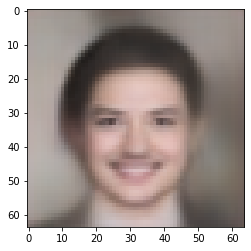

In [517]:
mu, sigma = 0, 1 #mean and standard deviation
z = np.random.normal(mu, sigma,64)
u = inner_decoder.predict(np.array([z]))
plt.imshow(unnormalize_tanh( decoder.predict([u,np.array([conditions])])[0]))
plt.show()

(1, 100)